In [1]:
!pip install --upgrade git+https://github.com/aleju/imgaug.git

  Cloning https://github.com/aleju/imgaug.git to /tmp/pip-req-build-aqxlpntu
  Running command git clone -q https://github.com/aleju/imgaug.git /tmp/pip-req-build-aqxlpntu
  Created wheel for imgaug: filename=imgaug-0.4.0-py3-none-any.whl size=970332 sha256=6c45f3151427f3b8eca044b3501b46c27af64b823a71d0214ead00aa1b17f870
  Stored in directory: /tmp/pip-ephem-wheel-cache-r1ijmnsb/wheels/0c/78/b5/9303fae9d5e03df1f319adfe4e6534180b5c3232de11bc9a2f
Successfully built imgaug
ERROR: albumentations 0.4.5 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.4.0 which is incompatible.
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.6
    Uninstalling imgaug-0.2.6:
      Successfully uninstalled imgaug-0.2.6
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import imgaug.augmenters as iaa
import numpy as np
import pandas as pd
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Dense
from keras.layers.convolutional import Conv2D
from keras.layers.core import Flatten, Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPool2D
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
# read data
df = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
predictions = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

# create mask for train-test split
msk = np.random.rand(len(df)) < 0.7

# train-test split [ 30% ]
train = df[msk]
test = test = df[~msk]

print("Train Samples: ", len(train))
print("Test Samples: ", len(test))

Train Samples:  29332
Test Samples:  12668


In [4]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)))
model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.15))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.15))

model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(10, activation="softmax"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 64)         

In [5]:
seq = iaa.Sequential([
    iaa.SomeOf((0, 1), [
        iaa.PiecewiseAffine(scale=(0.01, 0.04)),
        iaa.PerspectiveTransform(scale=(0.01, 0.04))
    ], random_order=True),
    iaa.SomeOf((0, 1), [
        iaa.geometric.Affine(rotate=(-7, 7)),
        iaa.geometric.Affine(shear=(-5, 5)),
    ], random_order=True)
])

In [6]:
def data_generator(mode, batch_size):
    while True:
        if mode == "train" :
            batch = train.sample(n=batch_size)
        else :
            batch = test.sample(n=batch_size)
        batch_x, batch_y = [], []
        for (index, row) in batch.iterrows():
            img = np.array(row[1:])
            img = img.reshape((28, 28, 1)).astype(np.uint8)
            batch_x.append(img)
            batch_y.append(row[0])
        batch_x = seq(images=batch_x)
        batch_x = np.array(batch_x).astype(np.float32)
        batch_y = np.array(batch_y)
        # batch_y = to_categorical(batch_y, num_classes=10)
        batch_x /= 255.0
        yield batch_x, batch_y

In [8]:
model.compile(
    optimizer=Adam(lr=0.0005),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [10]:
batch_size = 64

history = model.fit_generator(
    data_generator("train", batch_size),
    epochs=25,
    steps_per_epoch= len(train) // batch_size,
    validation_data=data_generator("test", batch_size),
    validation_steps=int(0.5 * len(train)) // batch_size,
    use_multiprocessing=True
)

Epoch 1/25
458/458 [==============================] - 131s 286ms/step - loss: 0.1483 - accuracy: 0.9578 - val_loss: 0.1255 - val_accuracy: 0.9742
Epoch 2/25
458/458 [==============================] - 127s 278ms/step - loss: 0.0714 - accuracy: 0.9785 - val_loss: 0.0377 - val_accuracy: 0.9808
Epoch 3/25
458/458 [==============================] - 128s 280ms/step - loss: 0.0517 - accuracy: 0.9846 - val_loss: 0.0740 - val_accuracy: 0.9843
Epoch 4/25
458/458 [==============================] - 130s 284ms/step - loss: 0.0406 - accuracy: 0.9871 - val_loss: 0.0420 - val_accuracy: 0.9867
Epoch 5/25
458/458 [==============================] - 129s 281ms/step - loss: 0.0369 - accuracy: 0.9888 - val_loss: 0.1044 - val_accuracy: 0.9866
Epoch 6/25
458/458 [==============================] - 132s 288ms/step - loss: 0.0320 - accuracy: 0.9907 - val_loss: 0.0701 - val_accuracy: 0.9874
Epoch 7/25
458/458 [==============================] - 130s 285ms/step - loss: 0.0270 - accuracy: 0.9916 - val_loss: 0.0067 -

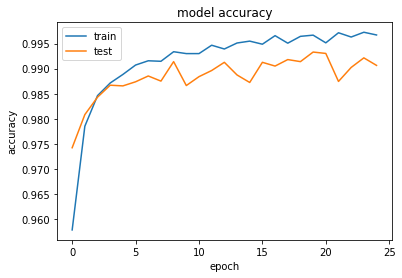

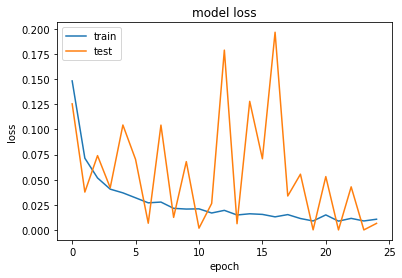

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:

# predict for submission
submission = []
for (index, row) in predictions.iterrows():
    img = np.array(row)
    x = img.reshape((1, 28, 28, 1)).astype(np.float32)
    x /= 255.0
    y = np.argmax(model.predict(x)[0])
    submission.append([index+1, y])

df = pd.DataFrame(submission, columns=["ImageId", "label"])
df.to_csv("/kaggle/working/submission.csv", index=False)
df.head(20)